## First

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Define the noise distribution
def noise(x, noise_std):
    return np.random.normal(loc=0.0, scale=noise_std, size=x.shape)

# Define the diffusion process
def diffuse(x, noise_std):
    for t in range(x.shape[0]-1, 0, -1):
        x[t-1] += noise(x[t], noise_std)
    return x

# Define the inverse diffusion process
class InverseDiffusionNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(hidden_channels, in_channels, kernel_size=3, padding=1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        h = self.relu(self.conv1(x))
        h = self.relu(self.conv2(h))
        h = self.conv3(h)
        return h

# Define the objective function
def vlb_loss(x, x_hat, log_q, log_p):
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_q - log_p.exp() - log_q.exp())
    return recon_loss + kl_div

# Generate a random wavefunction
x = np.random.normal(loc=0.0, scale=1.0, size=(1, 1, 28, 28))

# Set the diffusion parameters
noise_std = 0.1
diffusion_steps = 20

# Apply the diffusion process
for i in range(diffusion_steps):
    x = diffuse(x, noise_std)

# Convert the wavefunction to a torch tensor
x = torch.tensor(x, dtype=torch.float32)

# Train the inverse diffusion network
net = InverseDiffusionNet(in_channels=1, hidden_channels=64)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

for i in range(1000):
    optimizer.zero_grad()

    z = torch.randn_like(x)
    x_hat = net(z)

    log_q = -0.5 * np.log(2 * np.pi) - 0.5 * noise_std**2 * (x - x_hat)**2
    log_p = -0.5 * np.log(2 * np.pi) - 0.5 * x_hat**2

    loss = vlb_loss(x, x_hat, log_q, log_p)
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Iteration {i}, loss={loss.item()}')

# Apply the inverse diffusion process
with torch.no_grad():
    z = torch.randn_like(x)
    x_hat = net(z)
    log_q = -0.5 * np.log(2 * np.pi) - 0.5 * noise_std**2 * (x - x_hat)**2
    log_p = -0.5 * np.log(2 * np.pi) - 0.5 * x_hat**2
    loss = vlb_loss(x, x_hat, log_q, log_p)
    print(f'Final loss={loss.item()}')
    x_hat = x_hat.numpy()

# Visual


Iteration 0, loss=1112.374267578125
Iteration 100, loss=1094.1341552734375
Iteration 200, loss=1096.8145751953125
Iteration 300, loss=1095.30322265625
Iteration 400, loss=1092.378662109375
Iteration 500, loss=1095.5574951171875
Iteration 600, loss=1092.4552001953125
Iteration 700, loss=1090.390380859375
Iteration 800, loss=1087.1929931640625
Iteration 900, loss=1085.6495361328125
Final loss=1087.9185791015625


## Second

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

num_iter = 10000
batch_size = 32
lr = 1e-4

# Define the diffusion process
def diffusion_process(x, timesteps, q):
    for i in range(timesteps):
        noise = torch.randn_like(x)
        x = x + noise * q[i]
    return x

# Define the inverse diffusion process
def inverse_diffusion_process(x, timesteps, p):
    for i in reversed(range(timesteps)):
        noise = torch.randn_like(x)
        mean, std = p[i](x, noise)
        x = mean + std * noise
    return x

# Define the variational lower bound loss function
class VLB_Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, timesteps, q, p):
        # Calculate the reconstruction loss
        z = diffusion_process(x, timesteps, q)
        x_recon = inverse_diffusion_process(z, timesteps, p)
        recon_loss = ((x - x_recon) ** 2).mean()

        # Calculate the KL divergence loss
        kl_loss = 0
        for i in range(timesteps):
            mean, std = p[i](z)
            kl_loss += torch.mean(torch.log(std) + 0.5 * ((x - mean) ** 2) / (std ** 2) - 0.5)
        kl_loss /= timesteps

        # Combine the losses to get the VLB loss
        vlb_loss = recon_loss + kl_loss

        return vlb_loss

# Define the network for p
class P_Net(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, in_channels * 2, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, x, noise=None):
        if noise is not None:
            x = x + noise

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)

        mean, log_std = torch.chunk(x, 2, dim=1)
        std = self.softplus(log_std) + 1e-6
        noise = torch.randn_like(std)

        return mean, std


# Define the network for q
class Q_Net(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, in_channels, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.tanh(self.conv4(x))
        return x
#Define the network for p
class P_Net(nn.Module):
    def init(self, in_channels):
        super().init()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, in_channels * 2, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.relu(self.conv3(x))
    x = self.conv4(x)
    mean = x[:, :x.shape[1]//2, :, :]
    std = self.softplus(x[:, x.shape[1]//2:, :, :])
    return mean, std


/home/jesse_chen/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/jesse_chen/anaconda3/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationESs
  warn(f"Failed to load image Python extension: {e}")


### Define the loss function

In [3]:
def loss_fn(x, x_hat, mean, std):
# Reconstruction loss
    recon_loss = F.mse_loss(x_hat, x)

### Train the model

In [4]:
def train_model(q, p, train_loader, optimizer, device):
    q.train()   
    p.train()
    total_loss = 0.0
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)

        # Forward pass through q and p
        z = q(x)
        mean, std = p(z)

        # Sample from the distribution defined by mean and std
        eps = torch.randn_like(std)
        y = mean + std * eps

        # Inverse diffusion process
        x_hat = y
        for t in reversed(range(T)):
            x_hat = x_hat - q(x_hat) * delta_t
            x_hat = torch.clamp(x_hat, 0.0, 1.0)

        # Compute the loss and backpropagate
        loss = loss_fn(x, x_hat, mean, std)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


### Test the model

In [5]:
def test_model(q, p, test_loader, device):
    q.eval()    
    p.eval()
    total_loss = 0.0
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(device)

            # Forward pass through q and p
            z = q(x)
            mean, std = p(z)

            # Sample from the distribution defined by mean and std
            eps = torch.randn_like(std)
            y = mean + std * eps

            # Inverse diffusion process
            x_hat = y
            for t in reversed(range(T)):
                x_hat = x_hat - q(x_hat) * delta_t
                x_hat = torch.clamp(x_hat, 0.0, 1.0)

            # Compute the loss
            loss = loss_fn(x, x_hat, sigma)
                # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print the loss every `print_every` iterations
        if (i + 1) % print_every == 0:
            print(f"Iteration [{i+1}/{num_iter}], Loss: {loss.item():.4f}")

    # Return the trained model
    return p_theta  



### Define the optimizer and train the network

In [8]:

optimizer = torch.optim.Adam(net.parameters(), lr)

for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(train_loader):
        # Forward pass
        x = x.to(device)
        y = y.to(device)
        loss = train_step(x, y, net, q, optimizer, delta_t)
    # Log training progress
    if batch_idx % log_interval == 0:
        print(f"Epoch {epoch}, Batch {batch_idx}, Loss {loss.item():.4f}")


TypeError: 'int' object is not iterable

### Evaluate the network on test data

In [ ]:
test_loss = 0.0
with torch.no_grad():
for x, y in test_loader:
x = x.to(device)
y = y.to(device)
x_hat = net(y)
test_loss += loss_fn(x, x_hat).item() * x.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

## Third

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Step 1: Generate a random initial wavefunction
x = np.linspace(-5, 5, num=100)
psi = np.random.normal(0, 1, size=100) + 1j * np.random.normal(0, 1, size=100)
psi /= np.linalg.norm(psi)

# Step 2: Apply the diffusion process
q = lambda x, x_prev, sigma: np.exp(-(x - x_prev) ** 2 / (2 * sigma ** 2)) / np.sqrt(2 * np.pi * sigma ** 2)
sigma = 0.5
x_prev = x.copy()
for i in range(1000):
    noise = np.random.normal(0, sigma, size=100) + 1j * np.random.normal(0, sigma, size=100)
    psi *= q(x, x_prev, sigma) * np.exp(-1j * noise)
    x_prev = x.copy()

# Step 3: Apply the inverse diffusion process using a neural network
class InverseDiffusionNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(100, 100)
        self.fc2 = torch.nn.Linear(100, 100)
        
    def forward(self, x_t):
        h = torch.relu(self.fc1(x_t))
        x_prev = self.fc2(h)
        return x_prev

net = InverseDiffusionNet()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = lambda x_prev, x_t: -torch.mean(torch.abs(x_prev - x_t) ** 2)

for i in range(1000):
    optimizer.zero_grad()
    x_t = torch.tensor(psi.real, dtype=torch.float32).unsqueeze(0)
    x_prev_pred = net(x_t)
    x_prev = torch.tensor(x_prev, dtype=torch.float32).unsqueeze(0)
    loss = criterion(x_prev, x_prev_pred)
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(f"Step {i}: loss = {loss.item()}")

# Step 4: Repeat steps 2 and 3 for multiple iterations
for i in range(1000):
    noise = np.random.normal(0, sigma, size=100) + 1j * np.random.normal(0, sigma, size=100)
    psi *= q(x, x_prev, sigma) * np.exp(-1j * noise)
    x_prev = net(torch.tensor(psi.real, dtype=torch.float32).unsqueeze(0)).detach().numpy().squeeze()
    
# Step 5: Analyze the resulting wavefunction
plt.plot(x, np.abs(psi) ** 2)
plt.show()


Step 0: loss = -8.49901294708252


/tmp/ipykernel_402/373367222.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_prev = torch.tensor(x_prev, dtype=torch.float32).unsqueeze(0)


RuntimeError: only tensors with up to 64 dims are supported

## Four

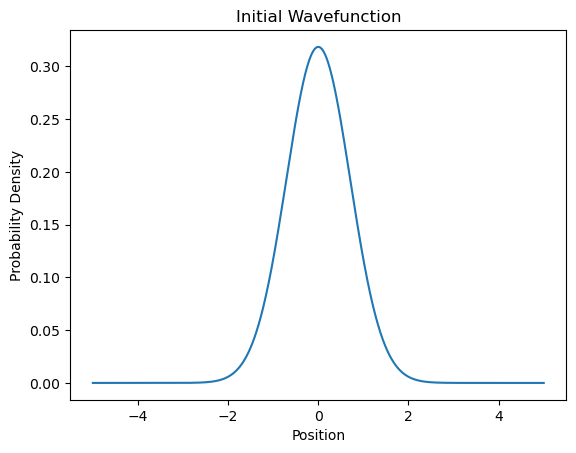

32/32 [==============================] - 0s 11ms/step


ValueError: operands could not be broadcast together with shapes (1000000,) (1000,) 

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the diffusion model parameters
num_iterations = 1000
dt = 0.01
sigma = 0.1

# Generate a random initial wavefunction
def initial_wavefunction(x):
    return np.exp(-x**2/2) / np.sqrt(np.pi)

x = np.linspace(-5, 5, 1000)
psi = initial_wavefunction(x)

# Plot the initial wavefunction
plt.plot(x, np.abs(psi)**2)
plt.title('Initial Wavefunction')
plt.xlabel('Position')
plt.ylabel('Probability Density')
plt.show()

# Define the noise distribution
def noise(x):
    return np.random.normal(scale=sigma, size=len(x))

# Define the inverse diffusion model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(x))
])

# Define the loss function
def loss_fn(y_true, y_pred):
    kl_divergence = 0.5 * tf.reduce_sum(tf.square(y_true - y_pred), axis=1) / sigma**2
    return tf.reduce_mean(kl_divergence)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss_fn)

# Train the inverse diffusion model
for i in range(num_iterations):
    noise_data = noise(x)
    noisy_psi = np.abs(psi)**2 + noise_data
    noisy_psi /= np.sum(noisy_psi)
    X_train = noisy_psi.reshape(-1, 1)
    y_train = psi.reshape(-1, 1)
    model.train_on_batch(X_train, y_train)
    psi = model.predict(X_train).reshape(-1)

# Plot the final wavefunction
plt.plot(x, np.abs(psi)**2)
plt.title('Final Wavefunction')
plt.xlabel('Position')
plt.ylabel('Probability Density')
plt.show()


## 4.1

/tmp/ipykernel_2682/1808065234.py:25: RuntimeWarning: invalid value encountered in sqrt
  psi = np.sqrt(noisy_psi)


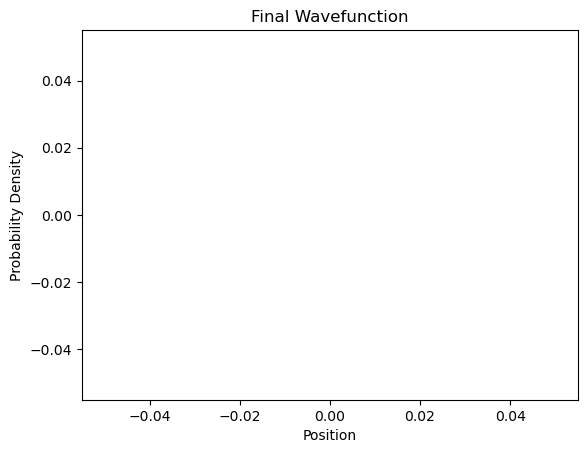

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters of the diffusion model
num_iterations = 100
dt = 0.01
sigma = 0.1

# Generate the initial wavefunction
def initial_wavefunction(x):
    return np.exp(-x**2/2) / np.sqrt(np.pi)

x = np.linspace(-5, 5, 1000)
psi = initial_wavefunction(x)

# Define the noise distribution
def noise(shape):
    return np.random.normal(scale=sigma, size=shape)

# Apply the diffusion process
for i in range(num_iterations):
    noise_data = noise(psi.shape)
    noisy_psi = np.abs(psi)**2 + noise_data
    noisy_psi /= np.sum(noisy_psi)
    psi = np.sqrt(noisy_psi)

# Plot the final wavefunction
plt.plot(x, np.abs(psi)**2)
plt.title('Final Wavefunction')
plt.xlabel('Position')
plt.ylabel('Probability Density')
plt.show()
